In [15]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics import cohen_kappa_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
import numpy as np
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *

stemmer = PorterStemmer()
from roc_utils import *
%matplotlib inline
from textblob import TextBlob
from textblob import Word
import string
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mnadella/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_excel('/mnt/storage/User_Feedback/Data/Daymaker Categorization.xlsx')

In [3]:
df.isna().sum()

Comments            4577
Action              8825
Daymaker sent          0
Positive comment       0
dtype: int64

In [4]:
df_=df[['Comments','Daymaker sent']].dropna()

In [5]:
df_.isna().sum()

Comments         0
Daymaker sent    0
dtype: int64

In [67]:
df_ = df_.astype({'Comments':'string'})

In [68]:
df_.dtypes

Comments            string
Daymaker sent        int64
Cleaned_Comments    object
dtype: object

In [8]:
df_

,Comments,Daymaker sent
0,Just wish I had known ahead of time Re:contras...,0
1,I had a problem with ME! While drinking the f...,0
2,I had a problem with ME! While drinking the f...,0
3,It was excellent. The staff did and excellent ...,1
4,"Staff was great- Beth, my RN, was professional...",0
...,...,...
13692,ARZ MCH Arizona Hospital - ARZ RAD CT PXMH,0
13693,ARZ MC Scottsdale - ARZ RAD MR SCMC,0
13694,ARZ MCH Arizona Hospital - ARZ RAD MR PXMH,0
13695,ARZ MCH Arizona Hospital - ARZ RAD CT PXMH,0


In [69]:
df_['Comments'].dtype

string[python]

In [10]:
df_  = df_.reset_index(drop=True)

In [11]:
df_

,Comments,Daymaker sent
0,Just wish I had known ahead of time Re:contras...,0
1,I had a problem with ME! While drinking the f...,0
2,I had a problem with ME! While drinking the f...,0
3,It was excellent. The staff did and excellent ...,1
4,"Staff was great- Beth, my RN, was professional...",0
...,...,...
9115,ARZ MCH Arizona Hospital - ARZ RAD CT PXMH,0
9116,ARZ MC Scottsdale - ARZ RAD MR SCMC,0
9117,ARZ MCH Arizona Hospital - ARZ RAD MR PXMH,0
9118,ARZ MCH Arizona Hospital - ARZ RAD CT PXMH,0


In [24]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    # TODO: Remove HTML tags and non-letters,
    #soup = BeautifulSoup(review, 'html5lib')
    text = review.lower()
    #       convert to lowercase, tokenize,
    text = re.sub(r"[^a-zA-Z0-9]", ' ', text.lower())
    words = text.split()
    #       remove stopwords and stem
    words = [w.strip() for w in words if w not in stopwords.words('english')]
    words = [stemmer.stem(w) for w in words]

    # Return final list of words
    return ' '.join(words)

In [25]:
df_['Cleaned_Comments'] = df_['Comments'].apply(review_to_words)

In [74]:
df_

,Comments,Daymaker sent,Cleaned_Comments
0,Just wish I had known ahead of time Re:contras...,0,wish known ahead time contrast bc plan see gra...
1,I had a problem with ME! While drinking the f...,0,problem drink fluid prepar test start uncontro...
2,I had a problem with ME! While drinking the f...,0,problem drink fluid prepar test start uncontro...
3,It was excellent. The staff did and excellent ...,1,excel staff excel job start finish
4,"Staff was great- Beth, my RN, was professional...",0,staff great beth profession made experi pleasa...
...,...,...,...
9115,ARZ MCH Arizona Hospital - ARZ RAD CT PXMH,0,much arizona hospit path
9116,ARZ MC Scottsdale - ARZ RAD MR SCMC,0,scottsdal mr
9117,ARZ MCH Arizona Hospital - ARZ RAD MR PXMH,0,much arizona hospit mr path
9118,ARZ MCH Arizona Hospital - ARZ RAD CT PXMH,0,much arizona hospit path


In [55]:
# !pip install textblob

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 636 kB 9.5 MB/s eta 0:00:01


In [128]:
from spellchecker import SpellChecker
spell = SpellChecker()

def b(x):
    text = x.lower()
#     text = re.sub(r"[^a-zA-Z0-9]", ' ', text.lower())
    words = text.split()
    y=[] 
    for word in words:
        y.append(spell.correction(word))
    try:
        if None in y:
            y[y.index(None)]=words[y.index(None)]
        return ' '.join(y)
    except:
        return ' '.join(words)


In [116]:
df_['Comments'].iloc[7116].split()[19]

'100%'

In [127]:
b(df_['Comments'].iloc[20])

'my experiences at mayo over the years has always been the best i was able to see the results on the portal just hours after testing and also my doctor gave me her thoughts of results promptly'

In [129]:
df_['Cleaned_text']=df_['Comments'].apply(b)

In [60]:
# from spellchecker import SpellChecker

# spell = SpellChecker()

# # find those words that may be misspelled
# misspelled = df_['Comments'].iloc[7000].split()

# for word in misspelled:
#     # Get the one `most likely` answer
#     print(spell.correction(word))

#     # Get a list of `likely` options
#     #print(spell.candidates(word))

In [136]:
LMmodel = SentenceTransformer('all-mpnet-base-v2')

In [137]:
X=df_['Comments']
y=df_['Daymaker sent']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, shuffle=True,test_size = .20)

In [139]:
X_train1=X_train.apply(review_to_words)

In [140]:
X_test1 = X_test.apply(review_to_words)

In [141]:
train_sentence_embeddings = LMmodel.encode(X_train1.values.tolist())
test_sentence_embeddings = LMmodel.encode(X_test1.values.tolist())

In [142]:
y_train = y_train
y_valid = y_test
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(train_sentence_embeddings, y_train) 
#xgb_prediction = xgb_model.predict_proba(test_sentence_embeddings)
print(classification_report(y_valid, xgb_model.predict(test_sentence_embeddings)))

[22:03:53] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

           0       0.73      0.87      0.79      1291
           1       0.40      0.22      0.28       533

    accuracy                           0.68      1824
   macro avg       0.57      0.54      0.54      1824
weighted avg       0.63      0.68      0.64      1824



In [143]:
df_new = pd.DataFrame({"Comments":list(X_test), "Comments_Proc":list(X_test1), "DayMakers":y_valid, "Prediction":xgb_model.predict(test_sentence_embeddings)})

In [144]:
df_new

,Comments,Comments_Proc,DayMakers,Prediction
3557,I was there on a Sunday for a 3:30 check-in an...,sunday 3 30 check bump patient person staff ke...,0,0
5195,My experience was excellent. I was very nervou...,experi excel nervou want take test tech calm s...,1,0
942,Radiology technician was very polite and effic...,radiolog technician polit effici excel experi,0,0
6295,"If I ever need these services again, I will go...",ever need servic go nowher els mayo avoid,1,0
7314,Well taken care of in a timely manner. Thank ...,well taken care time manner thank,1,0
...,...,...,...,...
8392,Probably the best radiology experience Iâ€™ve ...,probabl best radiolog experi ever nurs took ba...,0,0
2538,It really was 100%. Didn't wait long. Amazingl...,realli 100 wait long amazingli friendli knowle...,0,0
3489,While under anesthesia my eyes dried out and i...,anesthesia eye dri lot pain wake cornea scratc...,0,0
584,"Experience was great for recent mri. On time, ...",experi great recent mri time explain process p...,0,0


In [22]:
df_new1 = df_new.reset_index(drop=True)

In [23]:
df_new1

,Comments,Comments_Proc,DayMakers,Prediction
0,I was there on a Sunday for a 3:30 check-in an...,sunday 3 30 check bump patient person staff ke...,0,0
1,My experience was excellent. I was very nervou...,experi excel nervou want take test tech calm s...,1,0
2,Radiology technician was very polite and effic...,radiolog technician polit effici excel experi,0,0
3,"If I ever need these services again, I will go...",ever need servic go nowher els mayo avoid,1,0
4,Well taken care of in a timely manner. Thank ...,well taken care time manner thank,1,0
...,...,...,...,...
1819,Probably the best radiology experience Iâ€™ve ...,probabl best radiolog experi ever nurs took ba...,0,0
1820,It really was 100%. Didn't wait long. Amazingl...,realli 100 wait long amazingli friendli knowle...,0,0
1821,While under anesthesia my eyes dried out and i...,anesthesia eye dri lot pain wake cornea scratc...,0,0
1822,"Experience was great for recent mri. On time, ...",experi great recent mri time explain process p...,0,0


In [24]:
df_new1.to_excel('/home/mnadella/NewPredictionfile.xlsx') 

In [25]:
df_correct = df_new1[df_new1["DayMakers"]==df_new1["Prediction"]]

In [26]:
df_correct

,Comments,Comments_Proc,DayMakers,Prediction
0,I was there on a Sunday for a 3:30 check-in an...,sunday 3 30 check bump patient person staff ke...,0,0
2,Radiology technician was very polite and effic...,radiolog technician polit effici excel experi,0,0
5,Everyone was just great. I wasn't crazy about ...,everyon great crazi least everyon made better ...,0,0
6,Everything was just fine. Prompt professional ...,everyth fine prompt profession servic alway thank,0,0
9,Everything was great. Employees were very hel...,everyth great employe help,0,0
...,...,...,...,...
1819,Probably the best radiology experience Iâ€™ve ...,probabl best radiolog experi ever nurs took ba...,0,0
1820,It really was 100%. Didn't wait long. Amazingl...,realli 100 wait long amazingli friendli knowle...,0,0
1821,While under anesthesia my eyes dried out and i...,anesthesia eye dri lot pain wake cornea scratc...,0,0
1822,"Experience was great for recent mri. On time, ...",experi great recent mri time explain process p...,0,0


In [27]:
df_wrong = df_new[df_new["DayMakers"]!=df_new["Prediction"]]

In [28]:
df_wrong

,Comments,Comments_Proc,DayMakers,Prediction
5195,My experience was excellent. I was very nervou...,experi excel nervou want take test tech calm s...,1,0
6295,"If I ever need these services again, I will go...",ever need servic go nowher els mayo avoid,1,0
7314,Well taken care of in a timely manner. Thank ...,well taken care time manner thank,1,0
3267,I appreciate the extreme professionalism and c...,appreci extrem profession care attitud team un...,1,0
3610,The radiology team did a great job. Fast and e...,radiolog team great job fast effici still thor...,0,1
...,...,...,...,...
6493,It was great first time I have been there. It...,great first time quick organ felt safe,1,0
6621,Everyone was very nice and explained things in...,everyon nice explain thing detail went help relax,1,0
7642,Excellent!,excel,1,0
1520,Quick service and friendly staff,quick servic friendli staff,0,1


In [29]:
df_correct1 = df_correct[df_correct["Prediction"]==1]

In [30]:
df_correct1

,Comments,Comments_Proc,DayMakers,Prediction
11,The team was efficient and knowledgeable and c...,team effici knowledg cordial,1,1
24,Everyone was wonderful,everyon wonder,1,1
54,Good visit. Team polite and professional.,good visit team polit profession,1,1
153,There was a 1/2 hour delay but the staff did a...,1 2 hour delay staff great job keep inform fri...,1,1
164,I HAD A VERY GOOD TEAM THAT GAVE ME EXCELENT ...,good team gave excel care help handiccap 100 s...,1,1
...,...,...,...,...
1767,On time with all procedures.,time procedur,1,1
1770,Everyone was very kind and attentive to me,everyon kind attent,1,1
1780,Very professional and prompt. Pretty relaxing...,profession prompt pretti relax discuss autom v...,1,1
1794,ABSOLUTELY FIRST CLASS !!!,absolut first class,1,1


In [31]:
df_correct2 = df_correct1.reset_index(drop=True)

In [32]:
df_correct2

,Comments,Comments_Proc,DayMakers,Prediction
0,The team was efficient and knowledgeable and c...,team effici knowledg cordial,1,1
1,Everyone was wonderful,everyon wonder,1,1
2,Good visit. Team polite and professional.,good visit team polit profession,1,1
3,There was a 1/2 hour delay but the staff did a...,1 2 hour delay staff great job keep inform fri...,1,1
4,I HAD A VERY GOOD TEAM THAT GAVE ME EXCELENT ...,good team gave excel care help handiccap 100 s...,1,1
...,...,...,...,...
112,On time with all procedures.,time procedur,1,1
113,Everyone was very kind and attentive to me,everyon kind attent,1,1
114,Very professional and prompt. Pretty relaxing...,profession prompt pretti relax discuss autom v...,1,1
115,ABSOLUTELY FIRST CLASS !!!,absolut first class,1,1


Text(0.5, 1.0, 'Confusion Matrix')

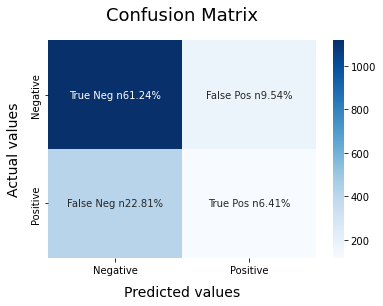

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_valid, xgb_model.predict(test_sentence_embeddings))
categories = ['Negative','Positive']
group_names = ['True Neg ','False Pos ', 'False Neg ','True Pos ']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
 

df_viz = pd.DataFrame([[df_.iloc[6295]['Comments'], 1, 0], [df_.iloc[7314]['Comments'], 1, 0], [df_.iloc[1520]['Comments'],0,1], [df_.iloc[3610]['Comments'], 0, 1], [df_.iloc[4432]['Comments'], 1, 1]],
                  columns=['Comments', 'DayMakers', 'Prediction'])
df_viz

,Comments,DayMakers,Prediction
0,"If I ever need these services again, I will go...",1,0
1,Well taken care of in a timely manner. Thank ...,1,0
2,Quick service and friendly staff,0,1
3,The radiology team did a great job. Fast and e...,0,1
4,There was a 1/2 hour delay but the staff did a...,1,1


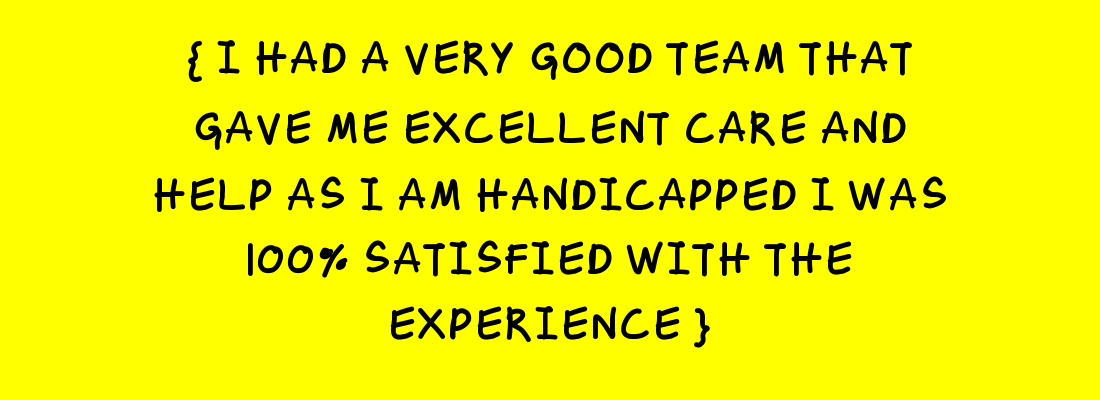

In [133]:
from PIL import Image, ImageDraw, ImageFont
from textwrap import wrap

def get_y_and_heights(text_wrapped, dimensions, margin, font):
    
    ascent, descent = font.getmetrics()

    # Calculate the height needed to draw each line of text (including its bottom margin)
    line_heights = [
        font.getmask(text_line).getbbox()[3] + descent + margin
        for text_line in text_wrapped
    ]
    # The last line doesn't have a bottom margin
    line_heights[-1] -= margin

    # Total height needed
    height_text = sum(line_heights)

    # Calculate the Y coordinate at which to draw the first line of text
    y = (dimensions[1] - height_text) // 2

    # Return the first Y coordinate and a list with the height of each line
    return (y, line_heights)


 
WIDTH = 1100
HEIGHT = 400
V_MARGIN =  10
CHAR_LIMIT = 30
BG_COLOR = "yellow"
TEXT_COLOR = "black"

text = "{ "+df_['Cleaned_text'].iloc[7116]+" }"

text = text.upper()

# Create the font
font = ImageFont.truetype("/home/mnadella/ZakirahsBold.ttf", 40)

# New image based on the settings defined above

img = Image.new("RGB", (WIDTH, HEIGHT), color=BG_COLOR)

# Interface to draw on the image
draw_interface = ImageDraw.Draw(img)

# Wrap the `text` string into a list of `CHAR_LIMIT`-character strings

text_lines = wrap(text, CHAR_LIMIT)

# Get the first vertical coordinate at which to draw text and the height of each line of text

y, line_heights = get_y_and_heights(
    text_lines,
    (WIDTH, HEIGHT),
    V_MARGIN,
    font
)

# Draw each line of text
for i, line in enumerate(text_lines):
    # Calculate the horizontally-centered position at which to draw this line
    line_width = font.getmask(line).getbbox()[2]
    x = ((WIDTH - line_width) // 2)

    # Draw this line
    draw_interface.text((x, y), line, font=font, fill=TEXT_COLOR)

    # Move on to the height at which the next line should be drawn at
    y += line_heights[i]

# Save the resulting image
display(img)

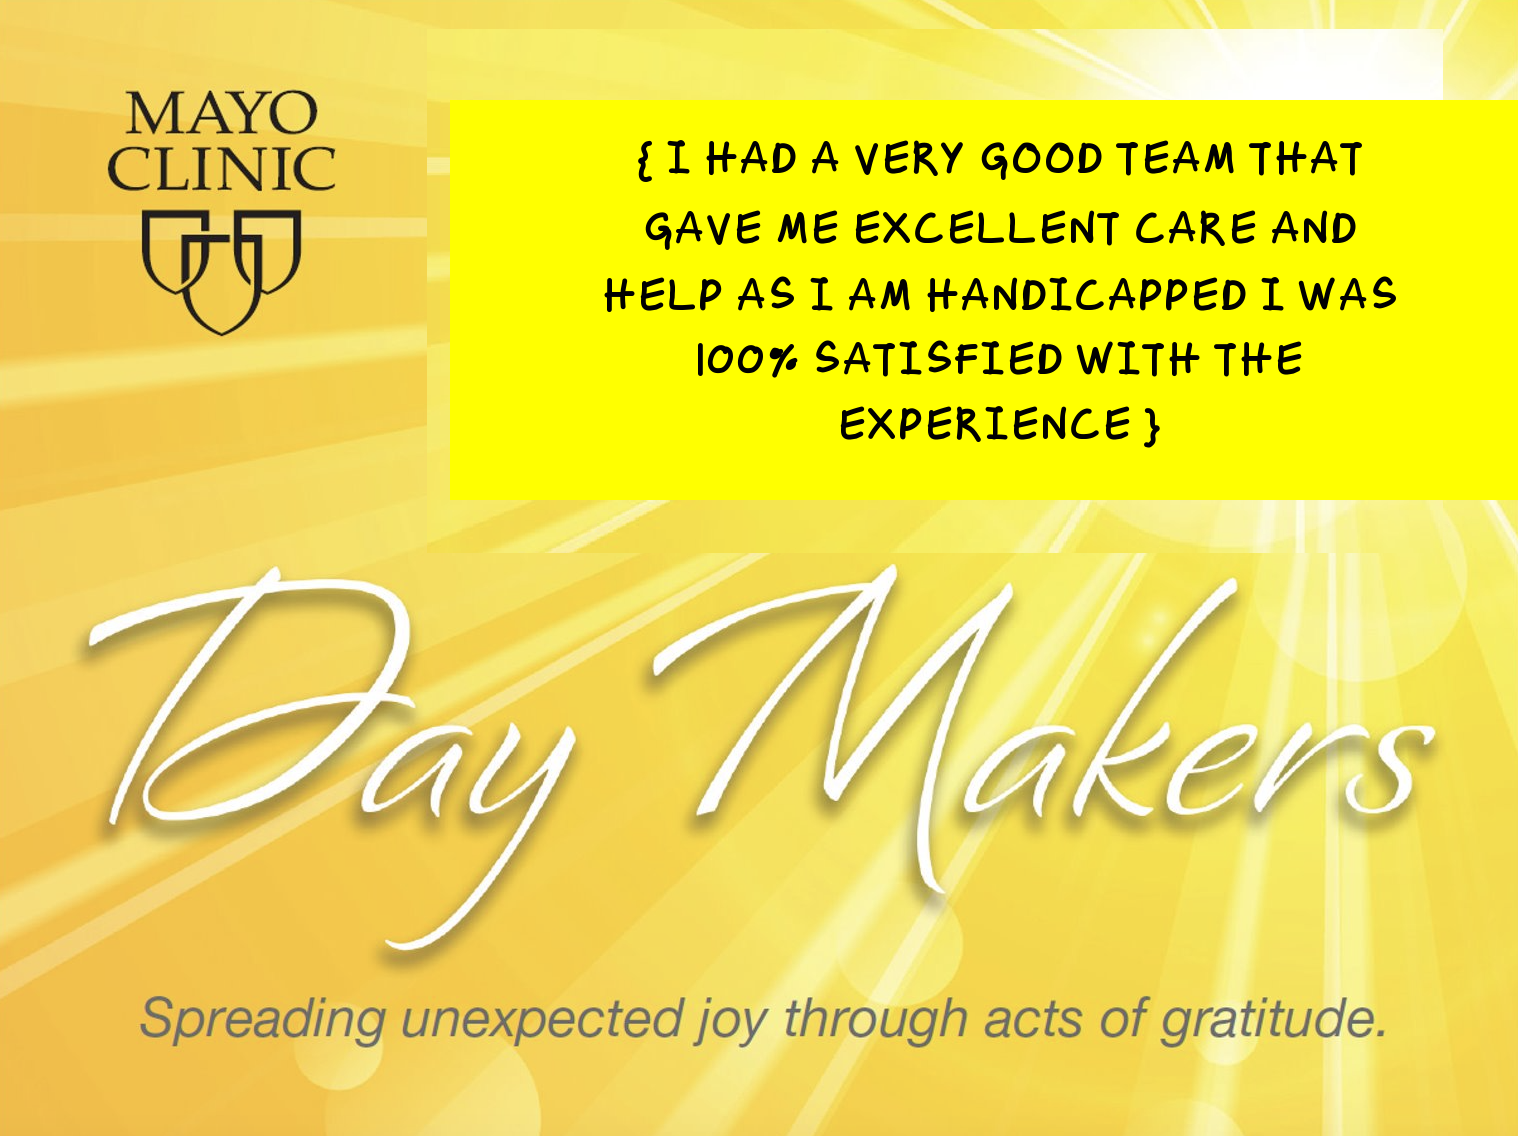

In [134]:
from PIL import Image
  
# Opening the primary image (used in background)
img1 = Image.open(r"/mnt/storage/User_Feedback/Data/Template.png")
  
# Opening the secondary image (overlay image)
img2 = img



img1.paste(img2, (450, 100))

display(img1)

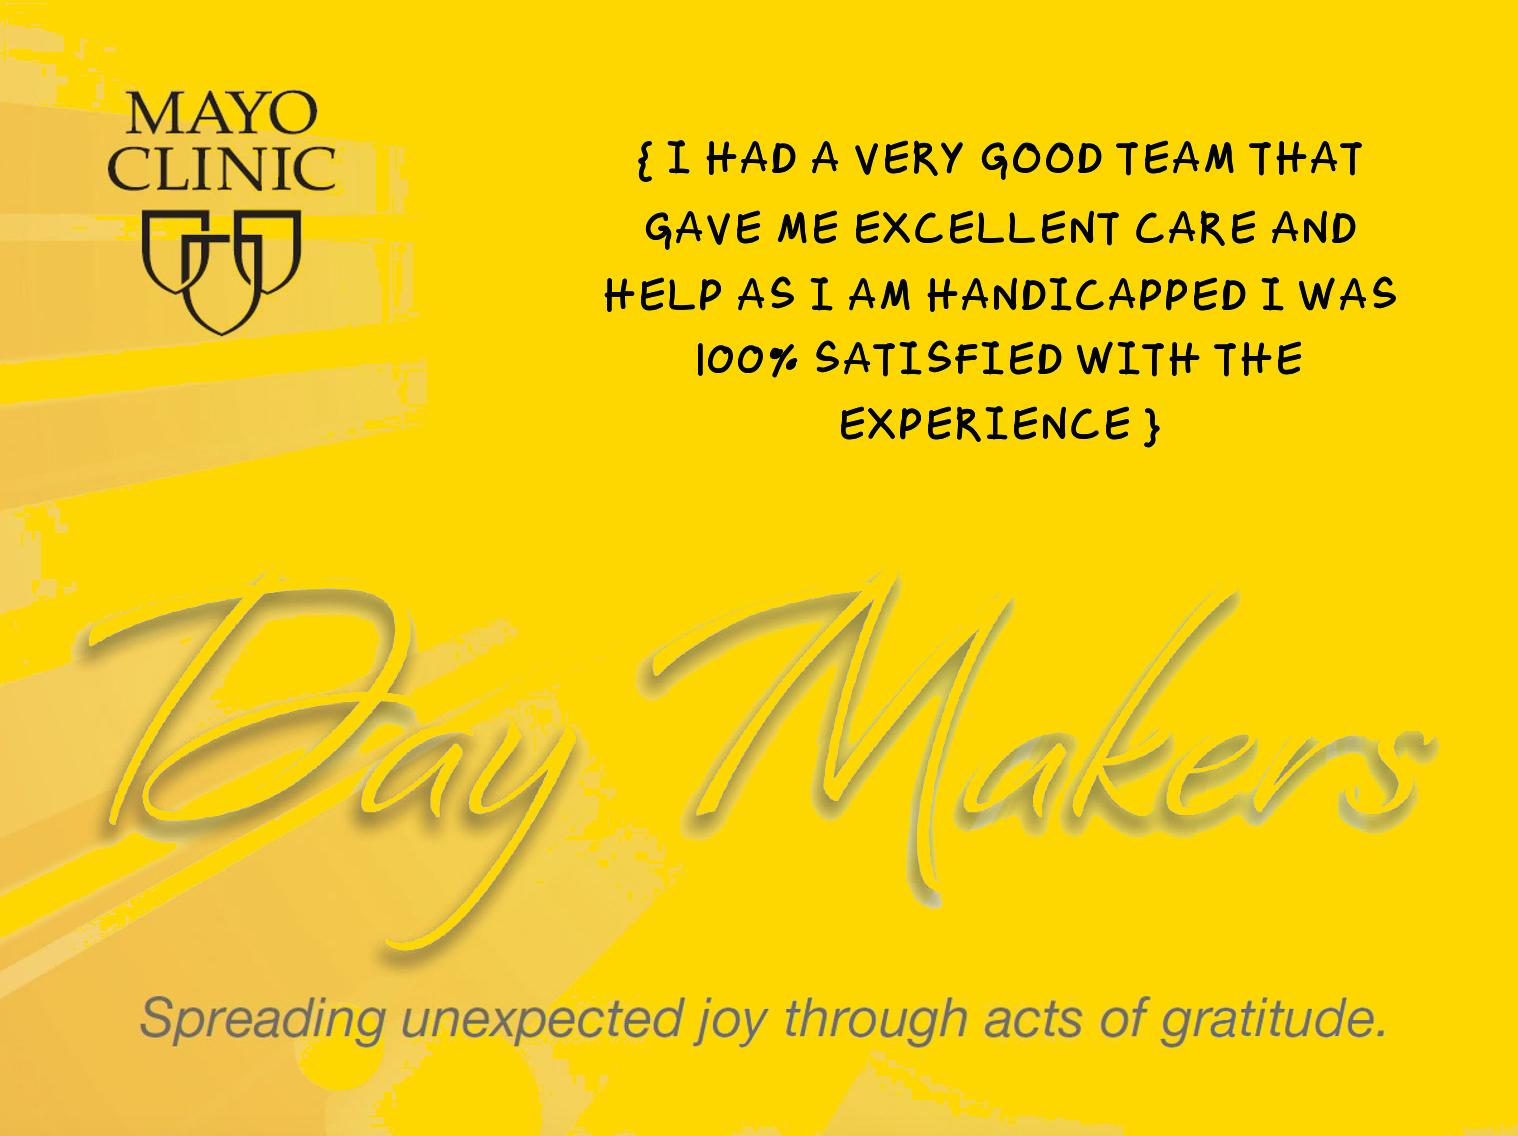

In [135]:
from PIL import Image
 
img_new = img1.convert("RGBA")
datas = img_new.getdata()

newData = []
for item in datas:
    if item[1] > 210:
        newData.append((255, 215, 0, 180))
    else:
        newData.append(item)
             


img_new.putdata(newData)

img_new1 = img_new.convert("RGB")

display(img_new1)